<a href="https://colab.research.google.com/github/TerMinator-spec/Stock-market-predictor/blob/master/Copy_of_gpu_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
%cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [359]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense, merge, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.relative_strength_index import relative_strength_index as rsi
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence as macd
#Used TA-Lib for creating additional features. More on this later.
# from talib.abstract import *
# from talib import MA_Type

In [4]:
!pip install pyti

In [ ]:
# import tensorflow as tf
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [360]:
def resample_stock_data(df, timedelta):
    # make a copy
        df = df.copy()

        # convert index to datetime
        df.index = pd.to_datetime(df.index)

        # sort the index (evidently required by resample())
        df = df.sort_index()

        aggregation_dict = {
             'open': 'first', 
             'high': 'max',
             'low': 'min',
             'close': 'last',

        }

        rename_dict = {
            'open': 'open',
            'high': 'high',
            'low': 'low',
            'close': 'close',

        }


        return (df
          .resample(timedelta)
          .agg(aggregation_dict)
          .rename(columns=rename_dict)
        )

In [361]:
import pandas as pd
import numpy as np
data=pd.read_csv('bankniftyoneminutefinal.csv')

In [362]:
data['date_time']=pd.to_datetime(data['date'] + ' ' + data['time'])

In [363]:
data.head()

,date,time,open,high,low,close,Unnamed: 6,date_time
0,1/9/2015,9:15:00,18845.9,18845.90,18801.70,18801.70,NaN,2015-01-09 09:15:00
1,1/9/2015,9:16:00,18801.7,18806.05,18790.20,18794.65,NaN,2015-01-09 09:16:00
2,1/9/2015,9:17:00,18796.0,18829.00,18794.65,18827.30,NaN,2015-01-09 09:17:00
3,1/9/2015,9:18:00,18827.3,18864.00,18827.30,18862.10,NaN,2015-01-09 09:18:00
4,1/9/2015,9:19:00,18862.1,18862.10,18843.55,18849.25,NaN,2015-01-09 09:19:00


In [364]:
data=data.drop('Unnamed: 6',axis=1)

In [365]:
data=data.set_index('date_time')

In [366]:
data_10=resample_stock_data(data,'10min')

In [367]:
data_10=data_10.dropna()

In [368]:
data_10.head()


,open,high,low,close
date_time,,,,
2015-01-09 09:10:00,18845.90,18864.00,18790.2,18849.25
2015-01-09 09:20:00,18849.25,18859.65,18799.4,18815.15
2015-01-09 09:30:00,18815.15,18821.40,18772.9,18800.05
2015-01-09 09:40:00,18800.05,18814.25,18758.5,18779.40
2015-01-09 09:50:00,18783.05,18808.30,18761.1,18802.90


In [369]:
DATA=data_10

In [370]:
DATA['hour'] = DATA.index.hour
DATA['day']  = DATA.index.weekday
DATA['week'] = DATA.index.week

DATA['close']  = pd.to_numeric(DATA['close'])
DATA['open']   = pd.to_numeric(DATA['open'])

DATA['avg_price']  = (DATA['low'] + DATA['high'])/2
DATA['range']      = DATA['high'] - DATA['low']
DATA['ohlc_price'] = (DATA['low'] + DATA['high'] + DATA['open'] + DATA['close'])/4
DATA['oc_diff']      = DATA['open'] - DATA['close']
DATA['RSI'] = rsi(DATA['close'],  14)
DATA['MACD'] = macd(DATA['close'], 12, 26)

# inputs = {
#     'open'   : DATA['open'].values,
#     'high'   : DATA['high'].values,
#     'low'    : DATA['low'].values,
#     'close'  : DATA['close'].values,
    
# }
DATA['ema'] = ema(DATA["close"], 15)
#DATA['ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
DATA['bear_power'] = DATA['low'] - DATA['ema']
DATA['bull_power'] = DATA['high'] - DATA['ema']
# Since computing EMA leave some of the rows empty, we want to remove them. (EMA is a lagging indicator)
DATA.dropna(inplace=True)
# Add 1D PCA vector as a feature as well. This helped increasing the accuracy by adding more variance to the feature set
pca_input = DATA.drop('close',1).copy()
pca_features = pca_input.columns.tolist()
pca = PCA(n_components=1)
DATA['pca'] = pca.fit_transform(pca_input.values.astype('float32'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [371]:
DATA.head()

,open,high,low,close,hour,day,week,avg_price,range,ohlc_price,oc_diff,RSI,MACD,ema,bear_power,bull_power,pca
date_time,,,,,,,,,,,,,,,,,
2015-01-09 13:20:00,18597.30,18606.10,18570.30,18600.15,13,4,2,18588.200,35.80,18593.4625,-2.85,35.446717,-57.375399,18621.286213,-50.986213,-15.186213,-10850.430664
2015-01-09 13:30:00,18600.15,18605.85,18568.80,18588.25,13,4,2,18587.325,37.05,18590.7625,11.90,34.374929,-54.296261,18613.478461,-44.678461,-7.628461,-10854.422852
2015-01-09 13:40:00,18590.00,18597.50,18571.30,18582.35,13,4,2,18584.400,26.20,18585.2875,7.65,33.828783,-52.099189,18606.025190,-34.725190,-8.525190,-10867.430664
2015-01-09 13:50:00,18578.00,18592.00,18493.80,18519.10,13,4,2,18542.900,98.20,18545.7250,58.90,28.585470,-55.830937,18590.966579,-97.166579,1.033421,-10945.405273
2015-01-09 14:00:00,18519.10,18529.30,18479.65,18521.25,14,4,2,18504.475,49.65,18512.3250,-2.15,28.988383,-55.531696,18578.798979,-99.148979,-49.498979,-11035.163086


In [372]:
len(DATA)

55075

In [373]:
dates=DATA.index

In [374]:
len(dates)

55075

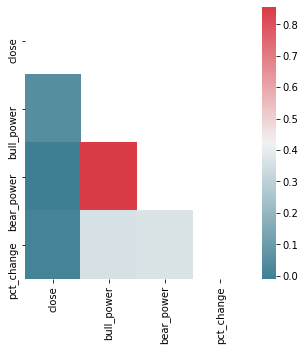

In [ ]:
t = DATA[['close', 'bull_power', 'bear_power']].copy()
t['pct_change'] = t['close'].pct_change()
t.dropna(inplace=True)
corr =  t.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax)

In [375]:
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [376]:
#TARGET     = 'USD_CAD'
#granuality = 'H1'
LOOK_BACK  = 30
SPLIT      = 0.80     # data split ration for training and testing

In [298]:
# Create scalers
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(DATA), columns=DATA.columns)
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = x_scaler.fit(DATA.drop('high', axis=1).values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(DATA['high'].values.astype('float32').reshape(-1,1))


In [377]:
# testing  dataset
# Create scalers
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(DATA), columns=DATA.columns)
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = x_scaler.fit(DATA.drop('close', axis=1).values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(DATA['close'].values.astype('float32').reshape(-1,1))

In [ ]:
y_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled.columns.tolist().index('high')

2

In [378]:
# Create dataset
target_index = scaled.columns.tolist().index('close')
dataset = scaled.values.astype('float32')
X, y = create_dataset(dataset, look_back=LOOK_BACK)
y = y[:,target_index]
train_size = int(len(X) * SPLIT)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [380]:
len(testY)

11009

In [381]:
dates_train, dates_test=create_dataset(dates, look_back=LOOK_BACK)

In [382]:
len(dates_test)

55044

In [383]:
len(dates_test[train_size:])

11009

In [301]:
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))

In [75]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard as tensorboard

In [302]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

In [303]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
# Enable this line if you want to monitor the trianing progress via TensorBoard
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=100, batch_size=500, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
80/80 [==============================] - 15s 126ms/step - loss: 0.2280 - mae: 0.4265 - mse: 0.2280 - val_loss: 0.7099 - val_mae: 0.8394 - val_mse: 0.7099
Epoch 2/100
80/80 [==============================] - 8s 105ms/step - loss: 0.2279 - mae: 0.4260 - mse: 0.2279 - val_loss: 0.7078 - val_mae: 0.8382 - val_mse: 0.7078
Epoch 3/100
80/80 [==============================] - 9s 108ms/step - loss: 0.1574 - mae: 0.3344 - mse: 0.1574 - val_loss: 0.1807 - val_mae: 0.4188 - val_mse: 0.1807
Epoch 4/100
80/80 [==============================] - 9s 109ms/step - loss: 0.0441 - mae: 0.1896 - mse: 0.0441 - val_loss: 0.0389 - val_mae: 0.1833 - val_mse: 0.0389
Epoch 5/100
80/80 [==============================] - 9s 108ms/step - loss: 0.0015 - mae: 0.0267 - mse: 0.0015 - val_loss: 0.0092 - val_mae: 0.0780 - val_mse: 0.0092
Epoch 6/100
80/80 [==============================] - 9s 108ms/step - loss: 3.8298e-04 - mae: 0.0123 - mse: 3.8298e-04 - val_loss: 0.0051 - val_mae: 0.0553 - val_mse: 0.0051
E

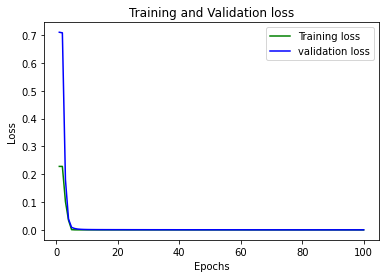

In [305]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [109]:
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%10==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=100, batch_size=500, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
80/80 [==============================] - 11s 88ms/step - loss: 0.1994 - mae: 0.3900 - mse: 0.1994 - val_loss: 0.3051 - val_mae: 0.5476 - val_mse: 0.3051
Epoch 2/100
80/80 [==============================] - 6s 75ms/step - loss: 0.0512 - mae: 0.1974 - mse: 0.0512 - val_loss: 0.1461 - val_mae: 0.3753 - val_mse: 0.1461
Epoch 3/100
80/80 [==============================] - 6s 76ms/step - loss: 0.0084 - mae: 0.0608 - mse: 0.0084 - val_loss: 0.0204 - val_mae: 0.1248 - val_mse: 0.0204
Epoch 4/100
80/80 [==============================] - 6s 75ms/step - loss: 7.1899e-04 - mae: 0.0179 - mse: 7.1899e-04 - val_loss: 0.0131 - val_mae: 0.0954 - val_mse: 0.0131
Epoch 5/100
80/80 [==============================] - 6s 75ms/step - loss: 4.7915e-04 - mae: 0.0148 - mse: 4.7915e-04 - val_loss: 0.0029 - val_mae: 0.0411 - val_mse: 0.0029
Epoch 6/100
80/80 [==============================] - 6s 74ms/step - loss: 3.2098e-04 - mae: 0.0133 - mse: 3.2098e-04 - val_loss: 0.0021 - val_mae: 0.0345 - val_mse

In [384]:
pred=model.predict(testX)

In [385]:
test2=y_scaler.inverse_transform(testY.reshape(-1,1))

In [386]:
pred2=y_scaler.inverse_transform(pred.reshape(-1,1))

In [387]:
len(test2)

11009

In [ ]:
pred2

array([[19292.383],
       [19248.344],
       [19274.38 ],
       ...,
       [29605.65 ],
       [29597.336],
       [29622.723]], dtype=float32)

In [ ]:
test2

array([[19055.8  ],
       [19453.25 ],
       [19483.049],
       ...,
       [29586.6  ],
       [29644.15 ],
       [29643.049]], dtype=float32)

In [388]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(test2,pred2)

In [389]:
mse

303651.78

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
def create_model(dropout_rate=0.0, optimizer="adam"):
  model = Sequential()
  model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(LSTM(20, return_sequences=True))
  #model.add(LSTM(10, return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(10, return_sequences=False))
  model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
  model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))
  model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
  return model

In [ ]:
seed = 7
np.random.seed(seed)
model = KerasRegressor(build_fn=create_model, verbose=0)

In [ ]:
batch_size = [ 25, 100, 300]
epochs = [20, 40, 90]
optimizer = ['SGD', 'RMSprop', 'Adam']
dropout_rate = [0.2, 0.3, 0.4]

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

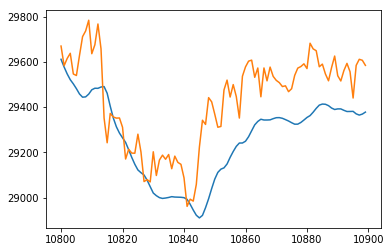

In [ ]:
plt.plot(df[-100:])

In [ ]:
regressor.save('my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets


In [189]:
model.save("model.h5")

In [328]:
model.save('model2.h5')

In [ ]:
from keras.models import load_model

In [234]:
model = load_model('model.h5')

In [235]:
pred=model.predict(X_test)

NameError: ignored

In [ ]:
len(y_test_dates[120:])

10900

In [390]:
dates_test

array([Timestamp('2015-01-12 12:00:00'), Timestamp('2015-01-12 12:10:00'),
       Timestamp('2015-01-12 12:20:00'), ...,
       Timestamp('2020-11-27 14:50:00'), Timestamp('2020-11-27 15:00:00'),
       Timestamp('2020-11-27 15:10:00')], dtype=object)

In [394]:
dicts={"test":list(test2.reshape(len(test2),)), 'pred': list(pred2.reshape(len(pred2),)), "datetime":dates_test[train_size:]}

In [393]:
len(dates_test)

55044

In [395]:
df=pd.DataFrame(dicts)

In [396]:
df.head(60)

,test,pred,datetime
0,29183.300781,29633.730469,2019-09-30 10:50:00
1,29211.701172,29611.185547,2019-09-30 11:00:00
2,29179.849609,29593.371094,2019-09-30 11:10:00
3,29161.199219,29576.556641,2019-09-30 11:20:00
4,29151.199219,29553.341797,2019-09-30 11:30:00
5,29226.001953,29522.302734,2019-09-30 11:40:00
6,29198.349609,29491.601562,2019-09-30 11:50:00
7,29170.701172,29472.636719,2019-09-30 12:00:00
8,29101.900391,29451.253906,2019-09-30 12:10:00
9,29057.750000,29415.572266,2019-09-30 12:20:00


In [397]:
df.set_index('datetime', inplace=True)

In [398]:
df.head()

,test,pred
datetime,,
2019-09-30 10:50:00,29183.300781,29633.730469
2019-09-30 11:00:00,29211.701172,29611.185547
2019-09-30 11:10:00,29179.849609,29593.371094
2019-09-30 11:20:00,29161.199219,29576.556641
2019-09-30 11:30:00,29151.199219,29553.341797


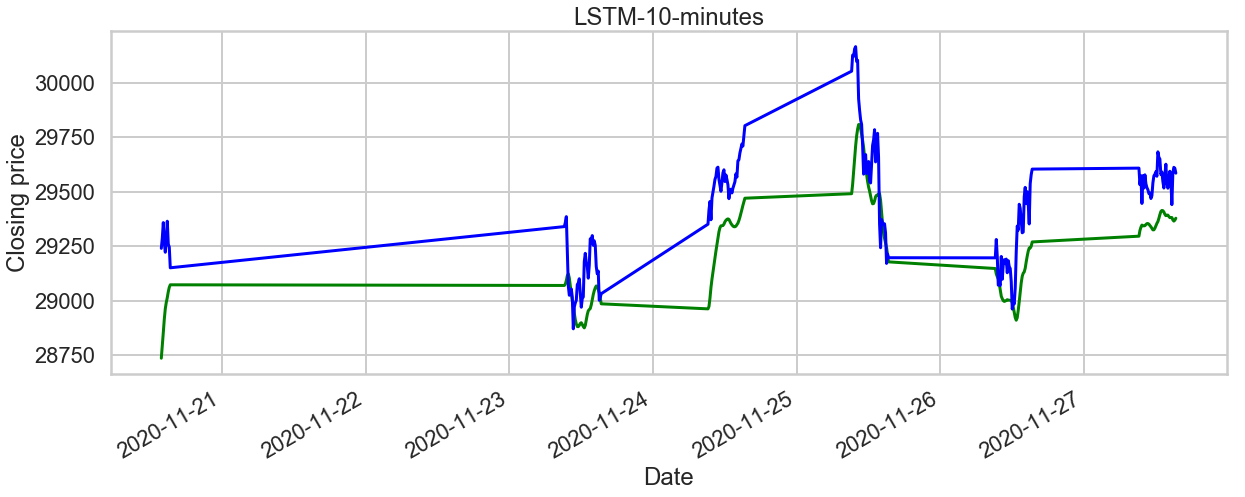

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
fig = plt.figure(figsize = (20,7))

sns.lineplot(x = "date", y = "pred", data=df[-200:],
             palette = "hot"
             ,color="green"
            )
sns.lineplot(x = "date", y = "test", data=df[-200:],
             palette = "hot"
             ,color="blue"
            )

fig.autofmt_xdate()

plt.title("LSTM-10-minutes") # for title
plt.xlabel("Date") # label for x-axis
plt.ylabel("Closing price") # label for y-axis
plt.show()

In [399]:
df['pred_lag']=df['pred'].shift(1)

In [400]:
df['test_lag']=df['test'].shift(1)

In [401]:
df=df.dropna()

In [402]:
r=0

In [403]:
df['position'] = np.where(df['pred']> (1+r)*df['pred_lag'], 1, -1) 

In [404]:
df['position_act']= np.where(df['test']> (1+r)*df['test_lag'], 1, -1) 

In [405]:
df.head(60)

,test,pred,pred_lag,test_lag,position,position_act
datetime,,,,,,
2019-09-30 11:00:00,29211.701172,29611.185547,29633.730469,29183.300781,-1,1
2019-09-30 11:10:00,29179.849609,29593.371094,29611.185547,29211.701172,-1,-1
2019-09-30 11:20:00,29161.199219,29576.556641,29593.371094,29179.849609,-1,-1
2019-09-30 11:30:00,29151.199219,29553.341797,29576.556641,29161.199219,-1,-1
2019-09-30 11:40:00,29226.001953,29522.302734,29553.341797,29151.199219,-1,1
2019-09-30 11:50:00,29198.349609,29491.601562,29522.302734,29226.001953,-1,-1
2019-09-30 12:00:00,29170.701172,29472.636719,29491.601562,29198.349609,-1,-1
2019-09-30 12:10:00,29101.900391,29451.253906,29472.636719,29170.701172,-1,-1
2019-09-30 12:20:00,29057.750000,29415.572266,29451.253906,29101.900391,-1,-1


In [ ]:
p_list=[]
for i in range(len(testX)):
  p1=model.predict(textX[i])
  p_list.append(p1)
  if(len(p_list)>1):
    if(p[-1]>p[-2]):
      position.append(1)



In [406]:
df['returns']=df['test'].pct_change()

In [407]:
df=df.dropna()

In [284]:
from sklearn.metrics import accuracy_score

In [408]:
accuracy_score(df['position_act'],df['position'])

0.49377668756246024

In [409]:
df["strategy"] = df["position"] * df["returns"]
#df.dropna(inplace=True)
df["creturns"] = (1+df["returns"]).cumprod()-1
df["cstrategy"] = (1+df["strategy"]).cumprod()-1

# absolute performance of the strategy
perf = df["cstrategy"].iloc[-1]

In [327]:
perf

0.48945466241272473

In [410]:
perf

0.4722705352902923

In [412]:
df.head()

,test,pred,pred_lag,test_lag,position,position_act,returns,strategy,creturns,cstrategy
datetime,,,,,,,,,,
2019-09-30 11:10:00,29179.849609,29593.371094,29611.185547,29211.701172,-1,-1,-0.001090,0.001090,-0.001090,0.001090
2019-09-30 11:20:00,29161.199219,29576.556641,29593.371094,29179.849609,-1,-1,-0.000639,0.000639,-0.001729,0.001730
2019-09-30 11:30:00,29151.199219,29553.341797,29576.556641,29161.199219,-1,-1,-0.000343,0.000343,-0.002071,0.002074
2019-09-30 11:40:00,29226.001953,29522.302734,29553.341797,29151.199219,-1,1,0.002566,-0.002566,0.000490,-0.000498
2019-09-30 11:50:00,29198.349609,29491.601562,29522.302734,29226.001953,-1,-1,-0.000946,0.000946,-0.000457,0.000448


In [413]:
df=df.reset_index(drop=False)

In [416]:
df.head()

,datetime,test,pred,pred_lag,test_lag,position,position_act,returns,strategy,creturns,cstrategy,date
0,2019-09-30 11:10:00,29179.849609,29593.371094,29611.185547,29211.701172,-1,-1,-0.001090,0.001090,-0.001090,0.001090,2019-09-30
1,2019-09-30 11:20:00,29161.199219,29576.556641,29593.371094,29179.849609,-1,-1,-0.000639,0.000639,-0.001729,0.001730,2019-09-30
2,2019-09-30 11:30:00,29151.199219,29553.341797,29576.556641,29161.199219,-1,-1,-0.000343,0.000343,-0.002071,0.002074,2019-09-30
3,2019-09-30 11:40:00,29226.001953,29522.302734,29553.341797,29151.199219,-1,1,0.002566,-0.002566,0.000490,-0.000498,2019-09-30
4,2019-09-30 11:50:00,29198.349609,29491.601562,29522.302734,29226.001953,-1,-1,-0.000946,0.000946,-0.000457,0.000448,2019-09-30


In [417]:
df['date']=df['datetime'].dt.date
df['hour']=df['datetime'].dt.hour
df['min']=df['datetime'].dt.minute

In [418]:
df.head()

,datetime,test,pred,pred_lag,test_lag,position,position_act,returns,strategy,creturns,cstrategy,date,hour,min
0,2019-09-30 11:10:00,29179.849609,29593.371094,29611.185547,29211.701172,-1,-1,-0.001090,0.001090,-0.001090,0.001090,2019-09-30,11,10
1,2019-09-30 11:20:00,29161.199219,29576.556641,29593.371094,29179.849609,-1,-1,-0.000639,0.000639,-0.001729,0.001730,2019-09-30,11,20
2,2019-09-30 11:30:00,29151.199219,29553.341797,29576.556641,29161.199219,-1,-1,-0.000343,0.000343,-0.002071,0.002074,2019-09-30,11,30
3,2019-09-30 11:40:00,29226.001953,29522.302734,29553.341797,29151.199219,-1,1,0.002566,-0.002566,0.000490,-0.000498,2019-09-30,11,40
4,2019-09-30 11:50:00,29198.349609,29491.601562,29522.302734,29226.001953,-1,-1,-0.000946,0.000946,-0.000457,0.000448,2019-09-30,11,50


In [345]:
call=[]
p=0
for i in range(2,len(df)):
  if(df['position'][i]==1 and df['position'][i-1]==1 and df['position'][i-2]==-1):
    call.append('buy')
    p=1
  elif(df['position'][i]==-1 and df['position'][i-1]==-1 and df['position'][i-2]==1):
    call.append('sell')
    p=-1
  elif((df['position'][i]==-1 and df['position'][i-1]==1) or (df['position'][i]==1 and df['position'][i-1]==-1)):
    call.append('Exit')
    p=0
  elif(df['position'][i]==1 and p==1):
    call.append('buy hold')
    
  elif(df['position'][i]==-1 and p==-1):
    call.append('sell hold')
    
  else:
    call.append('No trade')

In [346]:
call.insert(0,'No trade')
call.insert(0,'No trade')

In [347]:
df['calls']=call

In [419]:
# testing phase
call=[]
p=0
for i in range(2,len(df)):
  if(df['position'][i]==1 and df['position'][i-1]==1 and df['position'][i-2]==-1):
    call.append('buy')
    p=1
  elif(df['position'][i]==-1 and df['position'][i-1]==-1 and df['position'][i-2]==1):
    call.append('sell')
    p=-1
  elif((df['position'][i]==-1 and df['position'][i-1]==1) or (df['position'][i]==1 and df['position'][i-1]==-1)):
    call.append('Exit')
    p=0
  elif(df['position'][i]==1 and p==1):
    call.append('buy hold')
    
  elif(df['position'][i]==-1 and p==-1):
    call.append('sell hold')
  elif(df['hour'][i]>15 and df['min'][i]>15):
    call.append('exit or no trade')
  else:
    call.append('No trade')
  if(df['hour'][i]>15 and df['min'][i]>25):
    p=0

In [420]:
#testing phase
call.insert(0,'No trade')
call.insert(0,'No trade')

In [421]:
df['calls']=call

In [422]:
df.head(60)

,datetime,test,pred,pred_lag,test_lag,position,position_act,returns,strategy,creturns,cstrategy,date,hour,min,calls
0,2019-09-30 11:10:00,29179.849609,29593.371094,29611.185547,29211.701172,-1,-1,-0.001090,0.001090,-0.001090,0.001090,2019-09-30,11,10,No trade
1,2019-09-30 11:20:00,29161.199219,29576.556641,29593.371094,29179.849609,-1,-1,-0.000639,0.000639,-0.001729,0.001730,2019-09-30,11,20,No trade
2,2019-09-30 11:30:00,29151.199219,29553.341797,29576.556641,29161.199219,-1,-1,-0.000343,0.000343,-0.002071,0.002074,2019-09-30,11,30,No trade
3,2019-09-30 11:40:00,29226.001953,29522.302734,29553.341797,29151.199219,-1,1,0.002566,-0.002566,0.000490,-0.000498,2019-09-30,11,40,No trade
4,2019-09-30 11:50:00,29198.349609,29491.601562,29522.302734,29226.001953,-1,-1,-0.000946,0.000946,-0.000457,0.000448,2019-09-30,11,50,No trade
5,2019-09-30 12:00:00,29170.701172,29472.636719,29491.601562,29198.349609,-1,-1,-0.000947,0.000947,-0.001404,0.001395,2019-09-30,12,0,No trade
6,2019-09-30 12:10:00,29101.900391,29451.253906,29472.636719,29170.701172,-1,-1,-0.002359,0.002359,-0.003759,0.003757,2019-09-30,12,10,No trade
7,2019-09-30 12:20:00,29057.750000,29415.572266,29451.253906,29101.900391,-1,-1,-0.001517,0.001517,-0.005270,0.005280,2019-09-30,12,20,No trade
8,2019-09-30 12:30:00,29054.550781,29377.900391,29415.572266,29057.750000,-1,-1,-0.000110,0.000110,-0.005380,0.005391,2019-09-30,12,30,No trade
9,2019-09-30 12:40:00,29019.101562,29334.314453,29377.900391,29054.550781,-1,-1,-0.001220,0.001220,-0.006593,0.006617,2019-09-30,12,40,No trade


In [423]:
pos=[]
for i in range(len(df)):
  if(df['calls'][i]=='buy' or df['calls'][i]=='buy hold'):
    pos.append(1)
  elif(df['calls'][i]=='sell' or df['calls'][i]=='sell hold'):
    pos.append(-1)
  else:
    pos.append(0)


In [424]:
df['position2']=pos

In [425]:
df["strategy"] = df["position2"] * df["returns"]
#df.dropna(inplace=True)
df["creturns"] = (1+df["returns"]).cumprod()-1
df["cstrategy"] = (1+df["strategy"]).cumprod()-1

# absolute performance of the strategy
perf = df["cstrategy"].iloc[-1]

In [352]:
perf

0.6357177553242095

In [426]:
perf

0.5949958622931832

In [ ]:
import seaborn as sns

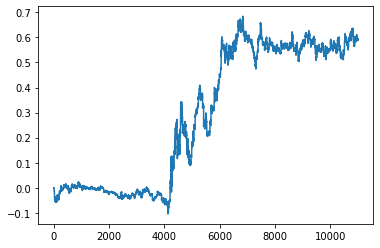

In [427]:
df['cstrategy'].plot()

In [ ]:
lits=[]
for i in range(len(df)-1):
    if((df['position'][i]==-1) and (df['position'][i+1]==1)):
        lits.append('buy')
    elif((df['position'][i]==1) and (df['position'][i+1]==-1)):
        lits.append('sell')
    elif(df['position'][i]==-1):
        lits.append('hold')
        
lits.append('over')

In [428]:
wealth_index=1000*(1+df['strategy']).cumprod()
previous_peak=wealth_index.cummax()
drawdown=(wealth_index-previous_peak)/previous_peak

In [429]:
min(drawdown)

-0.18898238974776826

In [ ]:
df["creturns"].iloc[-1]

0.012304199751778988

In [ ]:
perf

6.32220009520673